# What's My Flight Status?: Using Flight Data to Predict Flight Delays
***
Author: Andre Layton
***

## Overview

One of the most common applications of supervised learning in the aviation industry is predicting flight delays. By analyzing historical data on flight delays, machine learning and deep learning algorithms can identify patterns and factors that correlate with delays. This information can then be used to predict if a particular flight is likely to be delayed. Carriers can use these predictions to take preemptive measures, such as adjusting schedules or re-routing passengers, in order to minimize the impact of delays and their sales.

## Business Problem

I’ve been hired to create an algorithm that can predict flight delays, which will eventually be deployed as an app for consumers to be able to track their flights. This is beneficial to both the airline and potential passengers – for the airline, it will help with flight logistics and reduce fees due to delays (i.e. tarmac fees, reimbursements, etc.). For passengers, the app will allow them to make delay arrangements and take measures ahead of time, and possibly save on delay expenses. While delays are frustrating whether expected or not, United aims to use this strategy to display company honesty and gain more control over their flights.

>Note: The ultimate objective is to develop an app for consumer use, but within the constraints of this analysis, the model will be saved and stored in the repository [here.](/best_model.h5)

<img src="https://res.cloudinary.com/sagacity/image/upload/c_crop,h_2799,w_4199,x_0,y_0/c_limit,dpr_auto,f_auto,fl_lossy,q_80,w_1080/shutterstock_402702424_dlgrgk.jpg" style="height:650px" />

## Data Understanding 

To start, I import all the necessary packages, and I set a seed for reproducibility purposes. Then, I load the data, which is split into two files - a text file (`.txt`) and a CSV file (`.csv`). The text file contains the metadata, which in this case contains various column names and a short description. The CSV file contains the flight data needed for analysis.

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report,\
                            ConfusionMatrixDisplay, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import joblib
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers, optimizers

# Create a seed for reproducibility
seed=24

In [2]:
# Load the metadata (column descriptions)
metadata = open("data/raw_data_documentation.txt", "r")
print(metadata.read())

AIRPORT_COORDINATES
	ORIGIN_AIRPORT_ID: 	Airport ID, matches to ORIGIN_AIRPORT_ID in other files
	DISPLAY_AIRPORT_NAME:  	Display Airport, matches to DISPLAY_AIRPORT_NAME in other files
	LATITUDE: 		Latitude for airport
	LONGITUDE: 		Longitude for airport

B43_AIRCRAFT_INVENTORY
	MANUFACTURE_YEAR: 	Manufacture year
	TAIL_NUM: 		Unique tail number, matches to TAIL_NUM in other files
	NUMBER_OF_SEATS: 	Number of seats on aircraft
	
CARRIER_DECODE
	AIRLINE_ID: 		Airport ID, matches to AIRLINE_ID in other files
	OP_UNIQUE_CARRIER: 	Carrier code, matches to OP_UNIQUE_CARRIER in other files
	CARRIER_NAME: 		Carrier name, matches to UNIQUE_CARRIER_NAME or CARRIER_NAME in other files

ONTIME_REPORTING_XX
	MONTH: 			Month
	DAY_OF_MONTH: 		Day of the month (1-31)
	DAY_OF_WEEK: 		Day of the week
	OP_UNIQUE_CARRIER: 	Carrier code, matches to OP_UNIQUE_CARRIER in other files
	TAIL_NUM: 		Unique tail number, matches to TAIL_NUM in other files
	OP_CARRIER_FL_NUM: 	Flight number
	ORIGIN_AIRPORT_ID: 	A

In [3]:
# Load the flight data
data = pd.read_csv('data/full_data_flightdelay.csv')

# Preview the first 10 records
data.head(10)

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,0800-0859,2,1,25,143,Southwest Airlines Co.,13056,...,8,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,1,29,191,Delta Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,1,27,199,Delta Air Lines Inc.,13056,...,18,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,1,27,180,Delta Air Lines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,1,10,182,Spirit Air Lines,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
5,1,7,0,0001-0559,3,1,10,180,Frontier Airlines Inc.,13056,...,5,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
6,1,7,0,0700-0759,6,1,29,186,Frontier Airlines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
7,1,7,1,0001-0559,7,1,10,186,Frontier Airlines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
8,1,7,0,0001-0559,7,1,10,180,Frontier Airlines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
9,1,7,0,0600-0659,8,1,27,186,Frontier Airlines Inc.,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


The dataframe above gives me an initial look into the dataset, but I will apply a few more methods to gain a better understanding (i.e. `info()`, `isna()`, etc.). These techniques will help me learn more about my data, including the existence of any missing values and the data types of each column.

In [4]:
# Print column information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489062 entries, 0 to 6489061
Data columns (total 26 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   MONTH                          int64  
 1   DAY_OF_WEEK                    int64  
 2   DEP_DEL15                      int64  
 3   DEP_TIME_BLK                   object 
 4   DISTANCE_GROUP                 int64  
 5   SEGMENT_NUMBER                 int64  
 6   CONCURRENT_FLIGHTS             int64  
 7   NUMBER_OF_SEATS                int64  
 8   CARRIER_NAME                   object 
 9   AIRPORT_FLIGHTS_MONTH          int64  
 10  AIRLINE_FLIGHTS_MONTH          int64  
 11  AIRLINE_AIRPORT_FLIGHTS_MONTH  int64  
 12  AVG_MONTHLY_PASS_AIRPORT       int64  
 13  AVG_MONTHLY_PASS_AIRLINE       int64  
 14  FLT_ATTENDANTS_PER_PASS        float64
 15  GROUND_SERV_PER_PASS           float64
 16  PLANE_AGE                      int64  
 17  DEPARTING_AIRPORT              object 
 18  LA

I can see the method above displays the data type for each feature. Another point is the amount of data present. There are over 6.4 million observations, which will need to be reduced considering I'm only interested in United Airlines flights. The method below filters out the records based on the airline, revealing there are over 600,000 observations that will be analyzed to build my algorithm. 

In [5]:
# Print airline information
data['CARRIER_NAME'].value_counts()

Southwest Airlines Co.          1296329
Delta Air Lines Inc.             938346
American Airlines Inc.           903640
United Air Lines Inc.            601044
SkyWest Airlines Inc.            584204
Midwest Airline, Inc.            300154
JetBlue Airways                  269596
Alaska Airlines Inc.             239337
American Eagle Airlines Inc.     228792
Comair Inc.                      219324
Endeavor Air Inc.                203827
Spirit Air Lines                 189419
Mesa Airlines Inc.               177600
Frontier Airlines Inc.           120872
Atlantic Southeast Airlines       99044
Hawaiian Airlines Inc.            74898
Allegiant Air                     42636
Name: CARRIER_NAME, dtype: int64

The first method also gives me an idea into whether there are any missing values in the dataset. To know for sure, I will apply some more methods that will take the sum of every missing value in each column and returns those values. I find that, fortunately, there are no missing values present in my data, which will make cleaning the data more straightforward.

In [6]:
# Find the amount of missing values in each column
data.isna().sum()

MONTH                            0
DAY_OF_WEEK                      0
DEP_DEL15                        0
DEP_TIME_BLK                     0
DISTANCE_GROUP                   0
SEGMENT_NUMBER                   0
CONCURRENT_FLIGHTS               0
NUMBER_OF_SEATS                  0
CARRIER_NAME                     0
AIRPORT_FLIGHTS_MONTH            0
AIRLINE_FLIGHTS_MONTH            0
AIRLINE_AIRPORT_FLIGHTS_MONTH    0
AVG_MONTHLY_PASS_AIRPORT         0
AVG_MONTHLY_PASS_AIRLINE         0
FLT_ATTENDANTS_PER_PASS          0
GROUND_SERV_PER_PASS             0
PLANE_AGE                        0
DEPARTING_AIRPORT                0
LATITUDE                         0
LONGITUDE                        0
PREVIOUS_AIRPORT                 0
PRCP                             0
SNOW                             0
SNWD                             0
TMAX                             0
AWND                             0
dtype: int64

## Data Preparation
Now that I've gotten an initial look, it's time to begin preparing the data for modeling. I will start by making a copy of the original dataset, then filtering the data to keep only flights taken with United Airlines. From my earlier observations, I can see that will greatly reduce the data from 6 million to a little over 600,000 records. 

In [7]:
# Make a copy of the dataset
data2 = data.copy()

In [8]:
# Filter United Airlines's records and list the first 10
data2 = data2.loc[data2['CARRIER_NAME'] == 'United Air Lines Inc.']
data2.head(10)

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
21,1,7,0,0800-0859,2,1,25,173,United Air Lines Inc.,13056,...,6,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
22,1,7,0,0800-0859,3,1,25,142,United Air Lines Inc.,13056,...,22,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
23,1,7,0,0900-0959,7,1,28,154,United Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
24,1,7,1,1000-1059,3,1,29,142,United Air Lines Inc.,13056,...,19,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
25,1,7,0,0600-0659,7,1,27,173,United Air Lines Inc.,13056,...,4,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
26,1,7,0,0700-0759,1,1,29,154,United Air Lines Inc.,13056,...,21,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
27,1,7,0,0600-0659,2,1,27,154,United Air Lines Inc.,13056,...,20,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
28,1,7,0,0600-0659,9,1,27,173,United Air Lines Inc.,13056,...,11,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
29,1,7,0,0001-0559,5,1,10,154,United Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
30,1,7,0,0600-0659,3,1,27,173,United Air Lines Inc.,13056,...,4,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


Next step is to remove all the columns I believe are unnecessary or irrelevant to my model. This will reduce my dimensions from 26 to 12, which includes my target column.

In [9]:
# Drop unnecessary columns and display column information 
cols_to_drop = ['SEGMENT_NUMBER', 'NUMBER_OF_SEATS', 'FLT_ATTENDANTS_PER_PASS', 'AVG_MONTHLY_PASS_AIRPORT', 
                'GROUND_SERV_PER_PASS', 'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'PREVIOUS_AIRPORT', 'AVG_MONTHLY_PASS_AIRLINE',
                'LATITUDE', 'LONGITUDE', 'CARRIER_NAME', 'CONCURRENT_FLIGHTS', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH']
data2 = data2.drop(cols_to_drop, axis=1)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601044 entries, 21 to 6489030
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MONTH              601044 non-null  int64  
 1   DAY_OF_WEEK        601044 non-null  int64  
 2   DEP_DEL15          601044 non-null  int64  
 3   DEP_TIME_BLK       601044 non-null  object 
 4   DISTANCE_GROUP     601044 non-null  int64  
 5   PLANE_AGE          601044 non-null  int64  
 6   DEPARTING_AIRPORT  601044 non-null  object 
 7   PRCP               601044 non-null  float64
 8   SNOW               601044 non-null  float64
 9   SNWD               601044 non-null  float64
 10  TMAX               601044 non-null  float64
 11  AWND               601044 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 59.6+ MB


Now that the columns have been reduced, I will look to do the same with the rows by dropping any duplicates that exist in my dataset. I will also rename some of the column names for easier comprehension, moving forward, and then shift the target column to the end of my dataframe.

In [10]:
# Find the number of duplicate records
data2.duplicated().sum()

18105

In [11]:
# Drop duplicates
data2.drop_duplicates(inplace=True)

In [12]:
# Rename the columns for easier comprehension & list the first 5 records
new_col_names = {'DEP_DEL15': 'DELAYED',
                'PRCP': 'PRECIPITATION',
                'SNWD': 'SNOW_ON_GROUND',
                'TMAX': 'MAX_TEMP_FOR_DAY',
                'AWND': 'MAX_WIND_FOR_DAY'}
data2 = data2.rename(new_col_names, axis=1)
data2.head()

,MONTH,DAY_OF_WEEK,DELAYED,DEP_TIME_BLK,DISTANCE_GROUP,PLANE_AGE,DEPARTING_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY
21,1,7,0,0800-0859,2,6,McCarran International,0.0,0.0,0.0,65.0,2.91
22,1,7,0,0800-0859,3,22,McCarran International,0.0,0.0,0.0,65.0,2.91
23,1,7,0,0900-0959,7,3,McCarran International,0.0,0.0,0.0,65.0,2.91
24,1,7,1,1000-1059,3,19,McCarran International,0.0,0.0,0.0,65.0,2.91
25,1,7,0,0600-0659,7,4,McCarran International,0.0,0.0,0.0,65.0,2.91


In [13]:
# Shift the target column to the end 
cols_at_end = ['DELAYED']
data2 = data2[[col for col in data2 if col not in cols_at_end] 
        + [col for col in cols_at_end if col in data2]]

# Preview the first 5 records to confirm the change
data2.head()

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PLANE_AGE,DEPARTING_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY,DELAYED
21,1,7,0800-0859,2,6,McCarran International,0.0,0.0,0.0,65.0,2.91,0
22,1,7,0800-0859,3,22,McCarran International,0.0,0.0,0.0,65.0,2.91,0
23,1,7,0900-0959,7,3,McCarran International,0.0,0.0,0.0,65.0,2.91,0
24,1,7,1000-1059,3,19,McCarran International,0.0,0.0,0.0,65.0,2.91,1
25,1,7,0600-0659,7,4,McCarran International,0.0,0.0,0.0,65.0,2.91,0


Now that the dataset has been cleaned up, I want to take a look at the distributions of both the features and the target. This will give me an idea of whether a class imbalance exists (which I suspect there does), and how the feature data is distributed within that imbalance. I'll start by getting a count of the records, based on the `'MONTH'` and `'DAY_OF_WEEK'` features. I plot these value counts, but I divide them based on the target variable - labeling the bars as `'Not Delayed'` or `'Delayed'`.

In [14]:
# Break down the records by month
data2['MONTH'].value_counts().sort_index()

1     43189
2     40457
3     49824
4     49038
5     51038
6     50529
7     52122
8     52538
9     47786
10    51477
11    46880
12    48061
Name: MONTH, dtype: int64

In [15]:
# Break down the records by days of the week
data2['DAY_OF_WEEK'].value_counts().sort_index()

1    86421
2    85043
3    84471
4    84973
5    86153
6    73156
7    82722
Name: DAY_OF_WEEK, dtype: int64

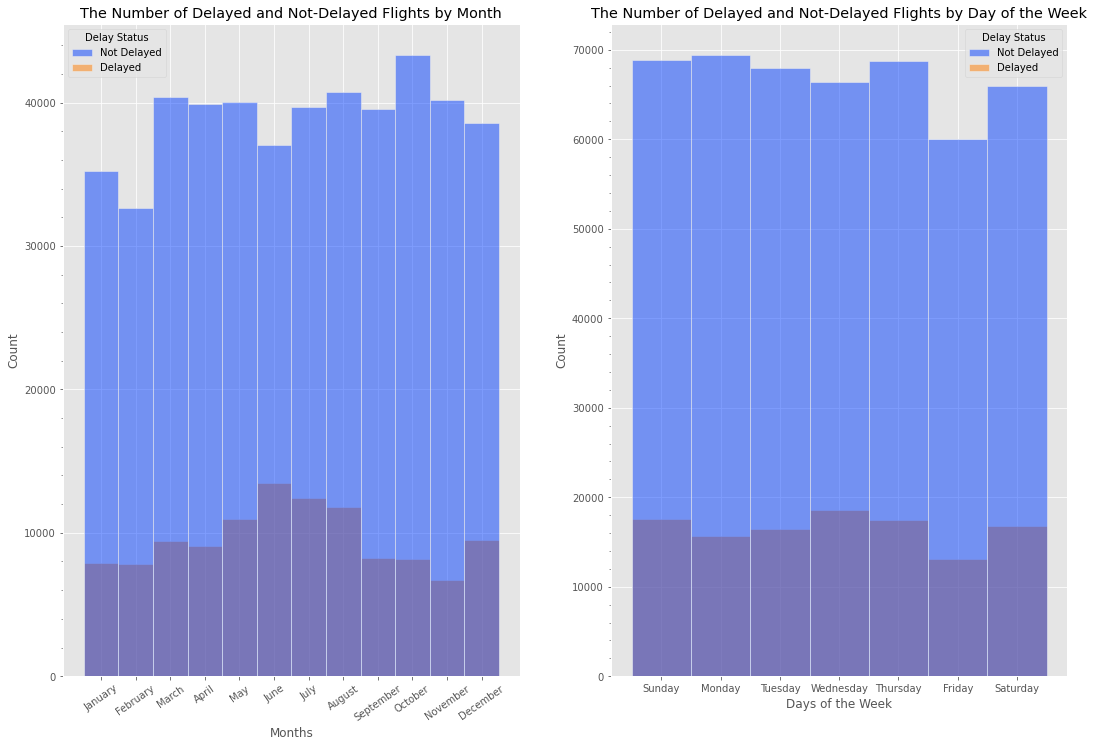

In [16]:
# Plot feature distributions

# Create month and days list objects
months = ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December']
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Visualize the delay status by month
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
plot1 = sns.histplot(data2, x='MONTH', hue='DELAYED', ax=ax[0], palette='bright', discrete=True)

# Change the legend labels
new_title = 'Delay Status'
plot1.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot1.legend_.texts, new_labels):
    t.set_text(l)
    
# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[0].yaxis.set_minor_locator(minor_locator)
ax[0].set_axisbelow(True)
plt.grid(which='both')
ax[0].tick_params(which="both", bottom=True)

# Change x-tick labels to months (written form) and rotate the labels
old_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ax[0].set_xticks(old_labels)
ax[0].set_xticklabels(months)
ax[0].tick_params(axis='x', labelrotation=35)
ax[0].set_xlabel("Months")
ax[0].set_title("The Number of Delayed and Not-Delayed Flights by Month")
    
# Visualize the delay status by days of the week    
plot2 = sns.histplot(data2, x='DAY_OF_WEEK', hue='DELAYED', ax=ax[1], palette='bright', discrete=True)

# Change the legend labels
new_title = 'Delay Status'
plot2.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot2.legend_.texts, new_labels):
    t.set_text(l)

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[1].yaxis.set_minor_locator(minor_locator)
ax[1].set_axisbelow(True)
plt.grid(which='both')

# Change x-tick labels to days (written form)
old_labels = [1, 2, 3, 4, 5, 6, 7]
ax[1].set_xticks(old_labels)
ax[1].set_xticklabels(days)
ax[1].set_xlabel("Days of the Week")
ax[1].set_title("The Number of Delayed and Not-Delayed Flights by Day of the Week");

Based on the visuals above, I see that there definitely exists a class imbalance in the dataset. In regard to the features, the first plot suggests that the summer months tend to see the highest number of delays, while the colder months seem to see less. In the second plot, the delays are highest on Wednesdays; although, the data seems to have low variation between the days of the week. 

The next few features are the `'DEP_TIME_BLK'` and the `'DISTANCE_GROUP'` columns. The first feature lists the time blocks for United Airlines flights, ranging from midnight (`'0001'`) to 11:59pm, and separated into hour blocks (except for the first block). The second feature lists all 11 distance groups, where the first group travels the shortest distance, and the eleventh group travels the farthest. 

In [17]:
# Break down the records by departure time blocks
data2['DEP_TIME_BLK'].value_counts().sort_index()

0001-0559    10189
0600-0659    42020
0700-0759    47223
0800-0859    42906
0900-0959    36314
1000-1059    35549
1100-1159    34927
1200-1259    35124
1300-1359    28503
1400-1459    33245
1500-1559    30224
1600-1659    35246
1700-1759    35880
1800-1859    36416
1900-1959    33797
2000-2059    21716
2100-2159    19542
2200-2259    12919
2300-2359    11199
Name: DEP_TIME_BLK, dtype: int64

In [18]:
# Break down the records by distance group
data2['DISTANCE_GROUP'].value_counts().sort_index()

1      29818
2      66963
3      80728
4     112096
5      65293
6      46784
7      60650
8      23843
9      16293
10     50679
11     29792
Name: DISTANCE_GROUP, dtype: int64

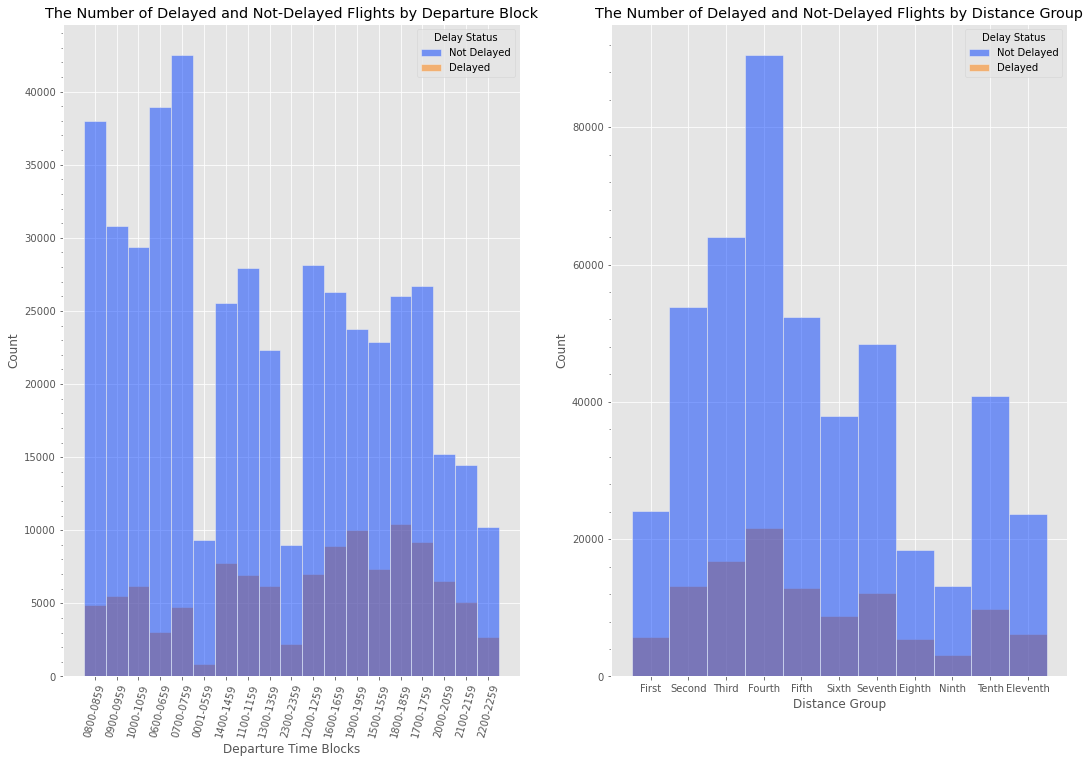

In [19]:
# Plot feature distributions
fig, ax = plt.subplots(1, 2, figsize=(18, 12))

# Visualize the delay status by departure time block
plot3 = sns.histplot(data2, x='DEP_TIME_BLK', hue='DELAYED', ax=ax[0], palette='bright', discrete=True)

# Change legend labels
new_title = 'Delay Status'
plot3.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot3.legend_.texts, new_labels):
    t.set_text(l)

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[0].yaxis.set_minor_locator(minor_locator)
ax[0].set_axisbelow(True)
plt.grid(which='both')

# Rotate x-tick labels
ax[0].tick_params(axis='x', labelrotation=75)
ax[0].tick_params(which="both", bottom=True)
ax[0].set_xlabel("Departure Time Blocks")
ax[0].set_title("The Number of Delayed and Not-Delayed Flights by Departure Block")
    
# Visualize the delay status by distance group  
plot4 = sns.histplot(data2, x='DISTANCE_GROUP', hue='DELAYED', ax=ax[1], palette='bright', discrete=True)

# Change legend labels
new_title = 'Delay Status'
plot4.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot4.legend_.texts, new_labels):
    t.set_text(l)
    
# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[1].yaxis.set_minor_locator(minor_locator)
ax[1].set_axisbelow(True)
plt.grid(which='both')

# Change x-tick labels to distance group (written form)
num_xlabels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
str_xlabels = ['First', 'Second', 'Third', 'Fourth', 'Fifth', 'Sixth', 'Seventh', 'Eighth', 'Ninth', 'Tenth', 'Eleventh']
ax[1].set_xticks(num_xlabels)
ax[1].set_xticklabels(str_xlabels)
ax[1].set_xlabel("Distance Group")
ax[1].set_title("The Number of Delayed and Not-Delayed Flights by Distance Group");

From what I see, the later time blocks (i.e., starting at 4pm to about 8pm) face the most delays. However, in the second visual, the third and fourth distance groups experience more delays, which is far less than those in higher distance groups. 

To be able to plot the rest of the features, I use both kdeplots and boxplots because the data within those columns are numerical and continuous in nature. I see that all six graphs contain outliers that affect the distribution one way or another, as well. 

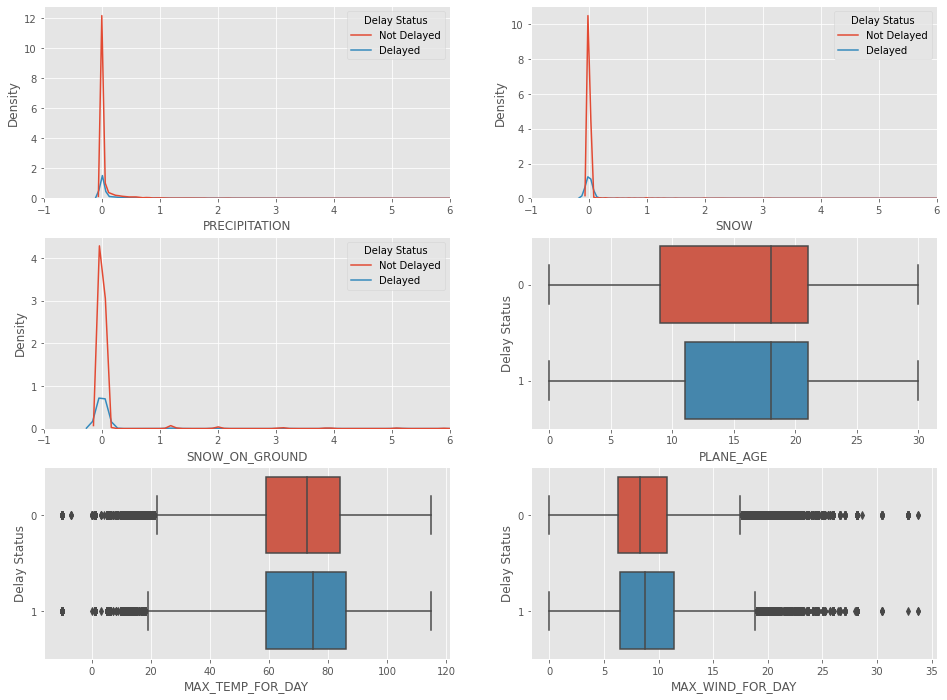

In [20]:
# Plot the remaining continuous variables with the delay status 
fig, ax = plt.subplots(3, 2, figsize=(16, 12))
kde1 = sns.kdeplot(data=data2, x="PRECIPITATION", hue="DELAYED", ax=ax[0,0])
kde2 = sns.kdeplot(data=data2, x="SNOW", hue="DELAYED", ax=ax[0,1])
kde3 = sns.kdeplot(data=data2, x="SNOW_ON_GROUND", hue="DELAYED", ax=ax[1,0])
box1 = sns.boxplot(data=data2, x="PLANE_AGE", y="DELAYED", orient='h', ax=ax[1,1])
box2 = sns.boxplot(data=data2, x="MAX_TEMP_FOR_DAY", y="DELAYED", orient='h', ax=ax[2,0])
box3 = sns.boxplot(data=data2, x="MAX_WIND_FOR_DAY", y="DELAYED", orient='h', ax=ax[2,1]);

# Change the legend in the kdeplots for better comprehension
kdeplots = [kde1, kde2, kde3]
for plot in kdeplots:
    new_title = 'Delay Status'
    plot.legend_.set_title(new_title)
    new_labels = ['Not Delayed', 'Delayed']
    for t, l in zip(plot.legend_.texts, new_labels):
        t.set_text(l)
    plot.set_xlim(-1, 6) 

# Change the y-axis label for the boxplots
boxplots = [box1, box2, box3]
for boxplot in boxplots:
    boxplot.set(ylabel='Delay Status')

It's time to examine the target, and confirm the class imbalance I mentioned earlier. First, I will plot my target as a bar plot, then as a pie chart. I plot both to show both the count and weight of each label in the dataset, respectively. 

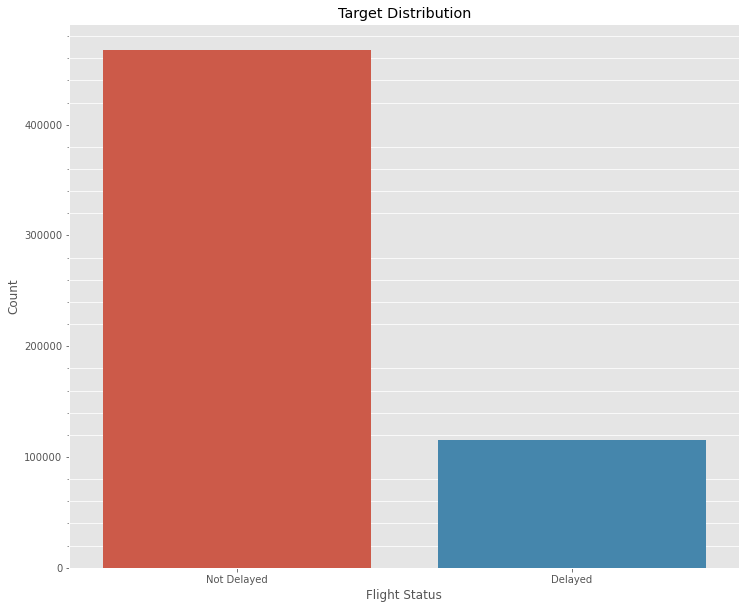

In [21]:
# Visualize the class (target) distribution
fig, ax = plt.subplots(figsize=(12,10))

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax.yaxis.set_minor_locator(minor_locator)
ax.set_axisbelow(True)
plt.grid(which='both')

# Plot the target 
sns.countplot(data=data2, x='DELAYED', orient='v')
ax.set_title('Target Distribution')

# Change x-tick labels and axis labels
old_labels = [0, 1]
new_xlabels = ['Not Delayed', 'Delayed']
ax.set_xticks(old_labels)
ax.set_xticklabels(new_xlabels)
ax.set_xlabel("Flight Status")
ax.set_ylabel("Count");

The bar plot above further confirms my speculation of a class imbalance - showing over 460,000 flights as `'Not Delayed'` and a little under 120,000 as `'Delayed'` flights. The pie plot below reinforces this observation, but displays the weight of each label in the data. I see that out of 600,000 flights, close to 20% are delayed - this is quite high considering the high amount of flights taken in a year through United. According to the Bureau of Transportation, 18.72% of flights in 2019 were delayed (all carriers included), meaning United exceeded the industry average.

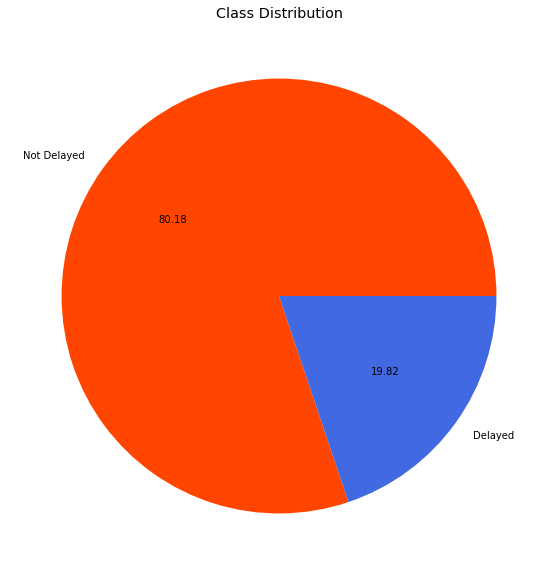

In [22]:
# Create a pie plot to further visualize the class distribution
fig, ax = plt.subplots(figsize=(12, 10))
data2['DELAYED'].value_counts().plot.pie(autopct='%.2f', title='Class Distribution', 
                                        labels=['Not Delayed', 'Delayed'], colors=['orangered', 'royalblue'])
ax.yaxis.set_visible(False);

I feel I've gained sufficient insight into how my data is structured and distributed; so, now it's time to begin modeling and building my algorithm. 

### Further Preprocessing:
In order to properly model my dataframe, I need to encode the categorical features into quanitative data. I can call scikit-learn's `OneHotEncoder` function to encode my five categorical columns into multiple, numerical columns; then list the shapes of all datasets to confirm the transformation. 

The dataset above will serve as my final dataframe, but I will also divide it into a training, testing and validation set. I will split the data 75/25, with 25% of the dataset reserved for the test set, and a seed set for reproducibility. Now, I will split the test data even further (by half, actually) into a smaller test set and a newly-formed validation set to iterate through my modeling process. I check the shape multiple times to be sure the data stays intact. 

In [23]:
# Split the dataset into training and testing sets
y = data2['DELAYED']
X = data2.drop('DELAYED', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=seed)
X_train.shape

(437204, 11)

In [24]:
# Split the test dataset in half to create a validation dataset
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=seed)
X_val.shape

(72868, 11)

Now that the data's been split, I can begin encoding each dataset separately. The test set will act as my "unseen data" and will be reserved for my final evaluation. As stated earlier, I will list the shapes just for peace of mind. 

In [25]:
# Encode categorical features
cols_to_encode = ['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP', 'DEPARTING_AIRPORT']
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train[cols_to_encode])
new_train_df = pd.DataFrame(ohe.transform(X_train[cols_to_encode]).todense(), 
                            columns=ohe.get_feature_names(), index=X_train.index)
X_train = pd.concat([X_train, new_train_df], axis=1).drop(cols_to_encode, axis=1)

In [26]:
val_df = pd.DataFrame(ohe.transform(X_val[cols_to_encode]).todense(), 
                      columns=ohe.get_feature_names(), index=X_val.index)
X_val = pd.concat([X_val.drop(cols_to_encode, axis=1), val_df], axis=1)

In [27]:
test_df = pd.DataFrame(ohe.transform(X_test[cols_to_encode]).todense(), 
                      columns=ohe.get_feature_names(), index=X_test.index)
X_test = pd.concat([X_test.drop(cols_to_encode, axis=1), test_df], axis=1)

In [28]:
# List the first five records to confirm the transformation
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(437204, 138)
(72868, 138)
(72867, 138)


Given the initial class imbalance, I need to apply a sampling technique - specifically, oversampling (SMOTE) - to augment the minority class (`'Delayed'`) in my target to an even ratio with the majority class (`'Not Delayed'`). I use the `Counter` function to show this change. I also plot the pie chart to display the new class weights, but this time expecting an even ratio.

In [29]:
# Count the number of classes before oversampling
counter = Counter(y_train)
print('Before sampling: ', counter)

# Instantiate the SMOTE function and oversample the training data
smt = SMOTE(random_state=seed) 
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# Count the number of classes after oversampling
counter_res = Counter(y_train_res)
print('After sampling: ', counter_res)

Before sampling:  Counter({0: 350513, 1: 86691})
After sampling:  Counter({0: 350513, 1: 350513})


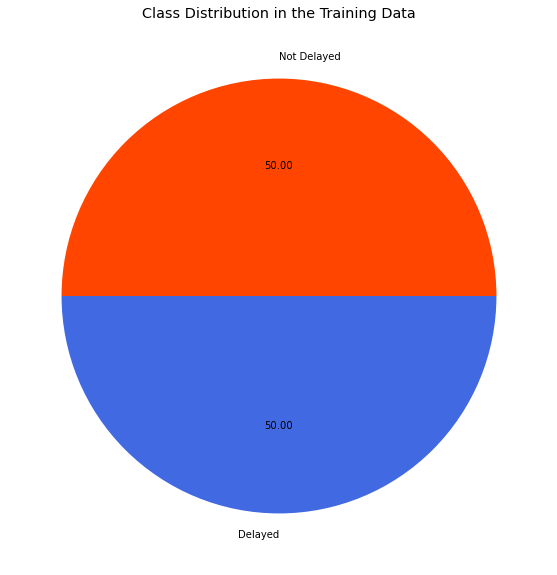

In [30]:
# Visualize the balanced class distribution
fig, ax = plt.subplots(figsize=(12, 10))
y_train_res.value_counts().plot.pie(autopct='%.2f', title='Class Distribution in the Training Data', 
                                        labels=['Not Delayed', 'Delayed'], colors=['orangered', 'royalblue'])
ax.yaxis.set_visible(False);

As shown above, the SMOTE method worked! To see just how much my training data has grown, I print the shape of the training data below. I see that the dataset now has **701,026 observations** to train my model on, and that the features remained intact. This increase in observations should improve my modeling performance and help me avoid any issues or controversy in results. The downside to this is the long run times I'm sure to experience due to my computational constraints.

In [31]:
# Print the balanced training data's shape
X_train_res.shape

(701026, 138)

## Modeling

Now it's time to begin modeling! I will create a few baseline models, to start, then cross-validate 4 different classifiers, and evaluate them based on precision, recall, and f1 scores. As a reminder, my main focus is to improve precision, which effects the number of false positive predictions. The false positive count, in this case, represents the amount of on-time flights predicted as delays. This could be detrimental if not addressed properly; the model could spread misinformation, and cause passengers to miss their on-time flights. This would lead to further client disapproval, and hurt United's sales and reputation. However, I will still track the recall score, and the f1 score, which is the harmonic mean of precision and recall. The baseline model with the best trio of average metric scores will be selected to undergo hyperparameter tuning and further evaluation.

### Baseline Modeling:

I will begin by using scikit-learn's `make_pipeline` function in order to pass a scaler and a classifier into my pipeline(s). I use this function over the library's long form version to avoid naming the estimators. I cross-validate these pipelines in 3 folds, then take the average of each score and print them for each classifier. 

In [32]:
# Make two lists, one containing classifier names and the other containing the classifiers
classifier_names = ['Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting']
classifiers = [DecisionTreeClassifier(random_state=seed), RandomForestClassifier(random_state=seed), 
               AdaBoostClassifier(random_state=seed), GradientBoostingClassifier(random_state=seed)]

# Loop through the two lists to create a pipeline, cross-validate the model, and print the relevant scores
for name, classifier in zip(classifier_names, classifiers):
    pipe = make_pipeline((MinMaxScaler()),
                          (classifier))
    score = cross_validate(pipe, X_train_res, y_train_res, cv=3, scoring=['precision', 'recall', 'f1'])
    model_scores = []
    keys = ['test_precision', 'test_recall', 'test_f1']
    for key in keys:
        model_scores.append(np.mean(score[key]))
    print("Validation precision, recall and f1 scores for {}: {}\n".format(name, model_scores))

Validation precision, recall and f1 scores for Decision Tree: [0.8416852479470313, 0.7756237594173561, 0.7595007602911071]

Validation precision, recall and f1 scores for Random Forest: [0.9313695562886423, 0.7666883474008875, 0.7864523707153354]

Validation precision, recall and f1 scores for AdaBoost: [0.8480503638132815, 0.691946367820922, 0.715686314340466]

Validation precision, recall and f1 scores for Gradient Boosting: [0.9371740386968425, 0.7141624780031419, 0.7516701938488651]



Based on the scores listed above, it seems that the Random Forest classifier outperforms the field, which eliminates the other models from further iteration. The Random Forest classifier is 93.1% precise, which is slightly lower than the Gradient Boosting model's score, but negligible enough that we can still go with the former. We can also justify this decision by taking a look at the two other metrics - the f1 score & the recall. As shown above, the Random Forest's set of scores are the highest among the four; thus, we can feel safe about selecting it as the "best" model for further analysis.  

93.1% validation precision is fantastic as a baseline, but also could be a sign that my model is overfitting. My next step will be trying to improve this start with some hyperparameter tuning. 

### Tuning the "Best" Baseline Model:

In order to keep in line with the business objectives, I need to set the `scoring` parameter to the three metrics I have been tracking so far. I will create a dictionary object that holds these three scores, and pass it into the `GridSearchCV` function. I will also pass a pipeline (long form this time) into the function, that will apply `MinMaxScaler` and my chosen classifier over the folds (in this case, 3) from the exhaustive grid search process. Because I'm using scikit-learn's long form pipeline function, it's vital I name each estimator in the steps parameter. My last step before fitting the grid search object is to create a parameter grid for the function to circulate through. It's important I don't forget to put the classifier name I choose as a prefix followed by two underscores before each parameter name in order to avoid error. Once I've set all the relevant parameters, I fit the grid search object.

>Note: Due to the number of fits, and depending on the computational constraints, this code can take over **2 hours** to fully run!

In [33]:
# Create a dictionary of relevant scoring metrics
scorers = {'precision_score': make_scorer(precision_score), 
           'recall_score': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

# Create a Pipeline with a scaler and classifier step
rf_pipe = Pipeline(steps=[('scaler', MinMaxScaler()),
                          ('classifier', RandomForestClassifier(random_state=seed))])

# Create a parameter grid for the Random Forest Classifier
rf_param_grid = {'classifier__n_estimators': [50, 100, 125], 
                 'classifier__max_depth': [None, 10, 20], 
                 'classifier__min_samples_leaf': [5, 10, 15]}

# Instantiate the GridSearchCV function with the 'refit' parameter set to 'precision_score'
rf_gridsearch = GridSearchCV(rf_pipe, rf_param_grid, scoring=scorers,
                              refit='precision_score', verbose=3, cv=3)

In [34]:
# Fit the GridSearchCV object
rf_gridsearch.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] classifier__max_depth=None, classifier__min_samples_leaf=5, classifier__n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__max_depth=None, classifier__min_samples_leaf=5, classifier__n_estimators=50, f1_score=0.423, precision_score=0.989, recall_score=0.269, total= 1.5min
[CV] classifier__max_depth=None, classifier__min_samples_leaf=5, classifier__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV]  classifier__max_depth=None, classifier__min_samples_leaf=5, classifier__n_estimators=50, f1_score=0.961, precision_score=0.941, recall_score=0.982, total= 1.7min
[CV] classifier__max_depth=None, classifier__min_samples_leaf=5, classifier__n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s


[CV]  classifier__max_depth=None, classifier__min_samples_leaf=5, classifier__n_estimators=50, f1_score=0.960, precision_score=0.941, recall_score=0.981, total= 1.7min
[CV] classifier__max_depth=None, classifier__min_samples_leaf=5, classifier__n_estimators=100 
[CV]  classifier__max_depth=None, classifier__min_samples_leaf=5, classifier__n_estimators=100, f1_score=0.422, precision_score=0.990, recall_score=0.268, total= 3.0min
[CV] classifier__max_depth=None, classifier__min_samples_leaf=5, classifier__n_estimators=100 
[CV]  classifier__max_depth=None, classifier__min_samples_leaf=5, classifier__n_estimators=100, f1_score=0.962, precision_score=0.942, recall_score=0.982, total= 3.3min
[CV] classifier__max_depth=None, classifier__min_samples_leaf=5, classifier__n_estimators=100 
[CV]  classifier__max_depth=None, classifier__min_samples_leaf=5, classifier__n_estimators=100, f1_score=0.962, precision_score=0.943, recall_score=0.982, total= 3.3min
[CV] classifier__max_depth=None, classif

[CV]  classifier__max_depth=10, classifier__min_samples_leaf=5, classifier__n_estimators=125, f1_score=0.871, precision_score=0.821, recall_score=0.929, total= 1.4min
[CV] classifier__max_depth=10, classifier__min_samples_leaf=5, classifier__n_estimators=125 
[CV]  classifier__max_depth=10, classifier__min_samples_leaf=5, classifier__n_estimators=125, f1_score=0.873, precision_score=0.823, recall_score=0.930, total= 1.4min
[CV] classifier__max_depth=10, classifier__min_samples_leaf=10, classifier__n_estimators=50 
[CV]  classifier__max_depth=10, classifier__min_samples_leaf=10, classifier__n_estimators=50, f1_score=0.545, precision_score=0.792, recall_score=0.416, total=  36.8s
[CV] classifier__max_depth=10, classifier__min_samples_leaf=10, classifier__n_estimators=50 
[CV]  classifier__max_depth=10, classifier__min_samples_leaf=10, classifier__n_estimators=50, f1_score=0.866, precision_score=0.810, recall_score=0.930, total=  36.5s
[CV] classifier__max_depth=10, classifier__min_sample

[CV]  classifier__max_depth=20, classifier__min_samples_leaf=10, classifier__n_estimators=100, f1_score=0.460, precision_score=0.936, recall_score=0.305, total= 2.1min
[CV] classifier__max_depth=20, classifier__min_samples_leaf=10, classifier__n_estimators=100 
[CV]  classifier__max_depth=20, classifier__min_samples_leaf=10, classifier__n_estimators=100, f1_score=0.927, precision_score=0.904, recall_score=0.952, total= 2.1min
[CV] classifier__max_depth=20, classifier__min_samples_leaf=10, classifier__n_estimators=100 
[CV]  classifier__max_depth=20, classifier__min_samples_leaf=10, classifier__n_estimators=100, f1_score=0.927, precision_score=0.903, recall_score=0.953, total= 2.1min
[CV] classifier__max_depth=20, classifier__min_samples_leaf=10, classifier__n_estimators=125 
[CV]  classifier__max_depth=20, classifier__min_samples_leaf=10, classifier__n_estimators=125, f1_score=0.462, precision_score=0.935, recall_score=0.307, total= 2.6min
[CV] classifier__max_depth=20, classifier__min

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 1215.6min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=24))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [5, 10, 15],
                         'classifier__n_estimators': [50, 100, 125]},
             refit='precision_score',
             scoring={'f1_score': make_scorer(f1_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)},
             verbose=3)

Now that the grid search has fully run, I can use the `best_params_` and `best_score_` attributes to find just that - the best parameters found through my grid search and the best cross-validated score of the best estimator, respectively. I see that my grid search determined 100 estimators and a minimum number of 5 samples per leaf in the Random Forest classifier were best, and refit the model based on these hyperparameters. The best score (0.931) is pretty high, and could be overfitting. I plot the confusion matrix to get a better look into how well this model does.

In [35]:
# Print the 'best' parameters and the best score for the model
print('Best params for Random Forest Classifier refit for {}:'.format('precision_score'))
print(rf_gridsearch.best_params_)
print('\n')
print('Best score for Random Forest Classifier refit for {}:'.format('precision_score'))
print(rf_gridsearch.best_score_)

Best params for Random Forest Classifier refit for precision_score:
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 100}


Best score for Random Forest Classifier refit for precision_score:
0.9583924767042996


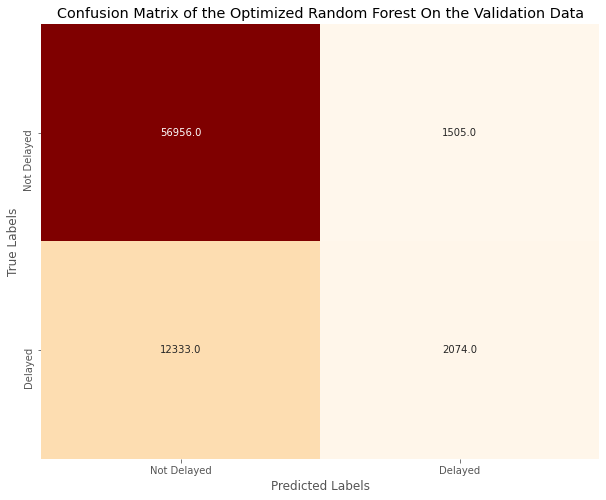

In [36]:
# Plot the confusion matrix
y_hat_val = rf_gridsearch.predict(X_val)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_val, y_hat_val), annot=True,
           fmt='.1f', xticklabels=['Not Delayed', 'Delayed'],
           yticklabels=['Not Delayed', 'Delayed'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title('Confusion Matrix of the Optimized Random Forest On the Validation Data')
plt.show();

From initial observation, I can see this model needs more training, especially if my hope is to reduce the false positive count while also predicting delays. The false positive count is 1,505, which is a decent start; however, there are 12,333 predictions misclassified as not delayed, which is a problem. I print the classification report below to get a full look into the grid search's metric scores, including recall and f1.

In [37]:
# Print the classification report
print(classification_report(y_val, y_hat_val))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     58461
           1       0.58      0.14      0.23     14407

    accuracy                           0.81     72868
   macro avg       0.70      0.56      0.56     72868
weighted avg       0.77      0.81      0.76     72868



The scores above (58.0%, 14.0%, 23.0%, respectively) is pretty low and invite more work. Due to constraints, I will accept these scores as the machine learning standard for comparison against another technique: deep learning. 

### Deep Learning:

Before I begin creating neural networks to train my data on, it's important I normalize the input datasets so that they are all on the same scale; otherwise, the models will generate flawed results. I will use `MinMaxScaler` once again, and transform all three input datasets, but only fitting on the training data.

In [38]:
# Use the MinMaxScaler function to scale the data
cols = X_train_res.columns

mmscaler = MinMaxScaler()
X_train_scaled = mmscaler.fit_transform(X_train_res)
X_val_scaled = mmscaler.transform(X_val)
X_test_scaled = mmscaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=cols)
X_val = pd.DataFrame(X_val_scaled, columns=cols)
X_test = pd.DataFrame(X_test_scaled, columns=cols)

# Check & reconfirm the training data's shape
X_train.shape

(701026, 138)

I see from the last line of code that the shape of the training data has remained intact, and that my data is ready to be modeled. To begin, I build a small baseline neural network - specifically, with 2 hidden layers and 1 output layer). I also set some regularization to help counter any potential overfitting to start. 

Seeing as how this is a classification problem, it's important I select loss and optimizer functions that work well in binary classification. From my knowledge, binary cross-entropy and Adam optimization work best in these situations, so I pass them along with a metrics parameter in the compiler function. The summary below shows the number of parameters that exist (and will be trained) in the network, which in this case is a little under 10,000 parameters!

In [1]:
# Create a small-layered baseline neural network
neural_network = Sequential()
neural_network.add(Dense(64, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01), input_shape=(138, )))
neural_network.add(Dense(16, activation='relu'))
neural_network.add(Dense(1, activation='sigmoid'))

# Compile the baseline network
neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# List a summary of the baseline network
neural_network.summary()

NameError: name 'Sequential' is not defined

I fit the baseline network to the training data, and run it for 32 epochs alongside the validation data.

In [40]:
# Fit the baseline network
baseline = neural_network.fit(X_train, y_train_res, epochs=32, batch_size=256,
                                      validation_data=(X_val, y_val))

Epoch 1/32
2739/2739 [==============================] - 8s 3ms/step - loss: 0.6046 - accuracy: 0.7025 - val_loss: 0.5941 - val_accuracy: 0.7216
Epoch 2/32
2739/2739 [==============================] - 8s 3ms/step - loss: 0.5060 - accuracy: 0.7684 - val_loss: 0.5717 - val_accuracy: 0.7414
Epoch 3/32
2739/2739 [==============================] - 10s 3ms/step - loss: 0.4885 - accuracy: 0.7790 - val_loss: 0.5472 - val_accuracy: 0.7631
Epoch 4/32
2739/2739 [==============================] - 8s 3ms/step - loss: 0.4806 - accuracy: 0.7838 - val_loss: 0.5586 - val_accuracy: 0.7469
Epoch 5/32
2739/2739 [==============================] - 10s 3ms/step - loss: 0.4760 - accuracy: 0.7868 - val_loss: 0.5401 - val_accuracy: 0.7698
Epoch 6/32
2739/2739 [==============================] - 9s 3ms/step - loss: 0.4727 - accuracy: 0.7886 - val_loss: 0.5612 - val_accuracy: 0.7521
Epoch 7/32
2739/2739 [==============================] - 9s 3ms/step - loss: 0.4706 - accuracy: 0.7903 - val_loss: 0.5329 - val_accurac

Once all the epochs have been run through, I evaluate the network on both the training and validation data to get a look into the baseline networks accuracy and loss. Then I generate predictions and map the values to plot a confusion matrix, and get a further look into how the model performed. 

21908/21908 [==============================] - 23s 1ms/step - loss: 12.7168 - accuracy: 0.5042
Training data results:
[12.716779708862305, 0.5041667222976685]


2278/2278 [==============================] - 2s 1ms/step - loss: 0.5528 - accuracy: 0.7676
Validation data results:
[0.5527992248535156, 0.7675934433937073]


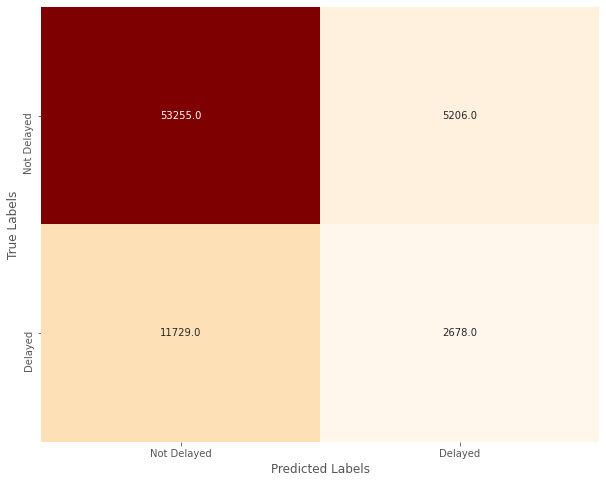

In [41]:
# Evaluate the loss and accuracy scores for the training and validation datasets
print(f'Training data results:\n{neural_network.evaluate(X_train_res, y_train_res)}')
print('\n')
print(f'Validation data results:\n{neural_network.evaluate(X_val, y_val)}')

# Generate predictions and "round" the values
baseline_preds = neural_network.predict(X_val)
baseline_preds[baseline_preds > 0.5] = 1
baseline_preds[baseline_preds < 0.5] = 0

# Plot a confusion matrix of the validation data
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_val, baseline_preds), annot=True,
           fmt='.1f', xticklabels=['Not Delayed', 'Delayed'],
           yticklabels=['Not Delayed', 'Delayed'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

I see above that the validation accuracy is much higher than the training data's score (76.8% vs. 50.4%, respectively). This is only a baseline network yet this performance is pretty poor and will need to be tuned and retrained. The confusion matrix above displays the model's performance, and gives us a better idea of how much work I need to do. When compared to the tuned machine learning model, the one above predicts more true positives (around 600 cases more) - essentially, more delay cases. Simultaneously, it predicts approximately 3500 more false positives. If possible, I will try to greatly reduce that amount while also increasing the amount of true delays. 

Below is the classification report for the baseline network to see how the model performed based on the three metrics I've been tracking thus far (precision, recall and f1 score). However, for this analsysis and simplicity's sake, I also create a function further below that will take in the true and predicted labels, and generate the three scores.

In [42]:
# Print the classification report
print(classification_report(y_val, baseline_preds))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     58461
           1       0.34      0.19      0.24     14407

    accuracy                           0.77     72868
   macro avg       0.58      0.55      0.55     72868
weighted avg       0.72      0.77      0.74     72868



In [43]:
# Create a function that will calculate the three relevant metric scores
def model_metrics(y_true, y_preds):
    
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)

    print('Precision score:', round(precision * 100, 2),'%')
    print('Recall score:', round(recall * 100, 2),'%')
    print('F1 score:', round(f1 * 100, 2),'%')

# Run the function with the appropriate arguments passed in
model_metrics(y_val, baseline_preds)

Precision score: 33.97 %
Recall score: 18.59 %
F1 score: 24.03 %


It seems all three scores dropped when compared to the machine learning algorithm. The precision score is the only one to decrease when compared to the Random Forest classifier (34.0% vs 58.0%). Conversely, the recall and f1 scores increased in this iteration. This means the model's sensitivity, or ability to predict positive results, has improved, which we saw in our plot above. My goal, once again, is to improve this area while maintaining low false positive numbers.

I will create another neural network; however, it will have 3 hidden layers, instead of two (and the units will be adjusted, accordingly). I apply the same compiler parameters, and print the summary again to see how many more parameters I am training. This denser network will train 11,249 total parameters.

In [44]:
# Create another, more dense neural network
neural_network2 = Sequential()
neural_network2.add(Dense(64, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01), input_shape=(138, )))
neural_network2.add(Dense(32, activation='relu'))
neural_network2.add(Dense(8, activation='relu'))
neural_network2.add(Dense(1, activation='sigmoid'))

# Compile the model
neural_network2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# List a summary of the model
neural_network2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                8896      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 11,249
Trainable params: 11,249
Non-trainable params: 0
_________________________________________________________________


I fit the model this time to **50 epochs** in order to increase my training performance, and in the hope that my precision will increase as well. I will retain the batch size and evaluate on the validation data again.

In [45]:
# Fit the model
results = neural_network2.fit(X_train, y_train_res, epochs=50, batch_size=256,
                                      validation_data=(X_val, y_val))

Epoch 1/50
2739/2739 [==============================] - 10s 4ms/step - loss: 0.5772 - accuracy: 0.7189 - val_loss: 0.5593 - val_accuracy: 0.7461
Epoch 2/50
2739/2739 [==============================] - 10s 4ms/step - loss: 0.4896 - accuracy: 0.7727 - val_loss: 0.5355 - val_accuracy: 0.7706
Epoch 3/50
2739/2739 [==============================] - 10s 4ms/step - loss: 0.4789 - accuracy: 0.7802 - val_loss: 0.6184 - val_accuracy: 0.6920
Epoch 4/50
2739/2739 [==============================] - 10s 4ms/step - loss: 0.4738 - accuracy: 0.7839 - val_loss: 0.5703 - val_accuracy: 0.7371
Epoch 5/50
2739/2739 [==============================] - 10s 4ms/step - loss: 0.4697 - accuracy: 0.7881 - val_loss: 0.5673 - val_accuracy: 0.7386
Epoch 6/50
2739/2739 [==============================] - 10s 4ms/step - loss: 0.4655 - accuracy: 0.7907 - val_loss: 0.5747 - val_accuracy: 0.7303
Epoch 7/50
2739/2739 [==============================] - 10s 4ms/step - loss: 0.4622 - accuracy: 0.7934 - val_loss: 0.5623 - val_ac

21908/21908 [==============================] - 23s 1ms/step - loss: 10.5074 - accuracy: 0.5081
Training data results:
[10.507423400878906, 0.5081394910812378]


2278/2278 [==============================] - 3s 1ms/step - loss: 0.5395 - accuracy: 0.7764
Validation data results:
[0.5395013093948364, 0.7764313817024231]


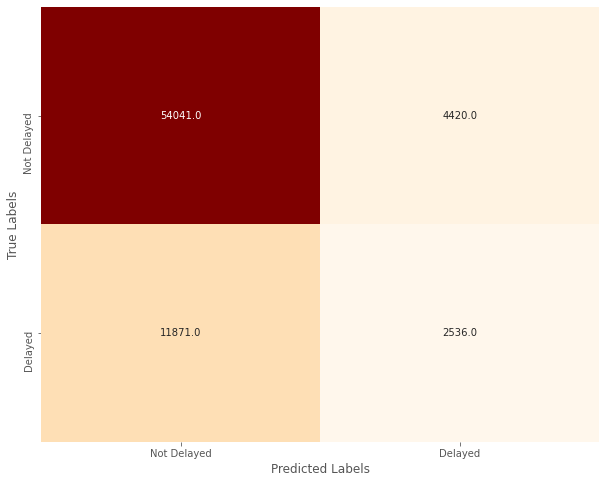

In [46]:
# Evaluate the loss and accuracy scores for the training and validation datasets
print(f'Training data results:\n{neural_network2.evaluate(X_train_res, y_train_res)}')
print('\n')
print(f'Validation data results:\n{neural_network2.evaluate(X_val, y_val)}')

# Generate predictions and "round" the values
y_preds2 = neural_network2.predict(X_val)
y_preds2[y_preds2 > 0.5] = 1
y_preds2[y_preds2 < 0.5] = 0

# Plot a confusion matrix of the validation data
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_val, y_preds2), annot=True,
           fmt='.1f', xticklabels=['Not Delayed', 'Delayed'],
           yticklabels=['Not Delayed', 'Delayed'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Based on the training and validation accuracies, I see that my model got better at misclassifying delayed flights! The true delays in my confusion matrix though got worse. My false positive cases reduced from 5206 to 4420, which is a good start towards my goals. However, my delay cases decreased slightly and needs to be improved. I print out the three metrics once again to get a better idea of my model's performance.

In [47]:
# Run the metrics function
model_metrics(y_val, y_preds2)

Precision score: 36.46 %
Recall score: 17.6 %
F1 score: 23.74 %


The three scores above tell me a few things. First, the precision score slightly increased to 36.5% and the remaining two scores decreased slightly, which is to be expected after seeing the true positive cases decrease. I will create one more neural network to try to improve my model's performance once again. Below I create another network, reverting back to my baseline architecture but with a smaller regularizer (0.001).

In [48]:
# Create a neural network similar to the baseline with a smaller regularizer
neural_network3 = Sequential()
neural_network3.add(Dense(64, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.001), input_shape=(138, )))
neural_network3.add(Dense(16, activation='relu'))
neural_network3.add(Dense(1, activation='sigmoid'))

# Compile the baseline model
neural_network3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# List a summary of the model
neural_network3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                8896      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 9,953
Trainable params: 9,953
Non-trainable params: 0
_________________________________________________________________


This iteration will differ from the other two networks I built by increasing the epochs to 128, setting a stopping condition with the `EarlyStopping` function, and saving that checkpoint as my best deep learning model with the `ModelCheckpoint` function. I will pass this stopping condition as I fit my model, evaluating it once again on my validation data. 

In [49]:
# Create a file name object for the best model checkpoint
model_filepath = 'deep_learning_model.h5'

# Set early stopping and model checkpoint conditions
early_stopping = [EarlyStopping(monitor='val_loss', patience=8), 
                  ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True)]

In [50]:
# Fit the model with more epochs
results2 = neural_network3.fit(X_train, y_train_res, epochs=128, batch_size=256, callbacks=early_stopping,
                                      validation_data=(X_val, y_val))

Epoch 1/128
2739/2739 [==============================] - 10s 4ms/step - loss: 0.5417 - accuracy: 0.7362 - val_loss: 0.5181 - val_accuracy: 0.7879
Epoch 2/128
2739/2739 [==============================] - 9s 3ms/step - loss: 0.4500 - accuracy: 0.7967 - val_loss: 0.5019 - val_accuracy: 0.7973
Epoch 3/128
2739/2739 [==============================] - 9s 3ms/step - loss: 0.4292 - accuracy: 0.8082 - val_loss: 0.5248 - val_accuracy: 0.7746
Epoch 4/128
2739/2739 [==============================] - 10s 3ms/step - loss: 0.4194 - accuracy: 0.8121 - val_loss: 0.5165 - val_accuracy: 0.7791
Epoch 5/128
2739/2739 [==============================] - 9s 3ms/step - loss: 0.4138 - accuracy: 0.8146 - val_loss: 0.5214 - val_accuracy: 0.7791
Epoch 6/128
2739/2739 [==============================] - 9s 3ms/step - loss: 0.4111 - accuracy: 0.8155 - val_loss: 0.5167 - val_accuracy: 0.7819
Epoch 7/128
2739/2739 [==============================] - 9s 3ms/step - loss: 0.4086 - accuracy: 0.8171 - val_loss: 0.5475 - val_

I see that my model has stopped after 10 epochs! Now I will take that saved model, load it, and evaluate the model on the training and validation data to view its accuracy. I will also plot the confusion matrix, and see how the model performed. 

In [51]:
# Load the saved model
saved_model = load_model(model_filepath)

# Calculate the loss and accuracy scores for both training datasets
results_train = saved_model.evaluate(X_train, y_train_res)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_val = saved_model.evaluate(X_val, y_val)
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

21908/21908 [==============================] - 23s 1ms/step - loss: 0.4425 - accuracy: 0.8037
Training Loss: 0.442 
Training Accuracy: 0.804
----------
2278/2278 [==============================] - 2s 1ms/step - loss: 0.5019 - accuracy: 0.7973
Validation Loss: 0.502 
Validation Accuracy: 0.797


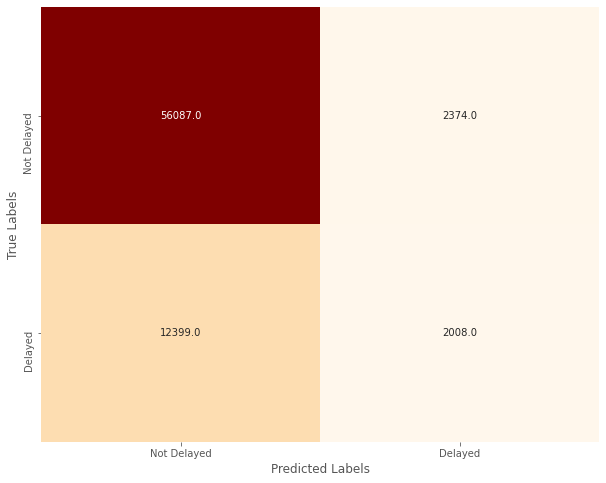

In [52]:
# Generate predictions and "round" the values
y_val_preds = saved_model.predict(X_val)
y_val_preds[y_val_preds > 0.5] = 1
y_val_preds[y_val_preds < 0.5] = 0

# Plot a confusion matrix of the validation data
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_val, y_val_preds), annot=True,
           fmt='.1f', xticklabels=['Not Delayed', 'Delayed'],
           yticklabels=['Not Delayed', 'Delayed'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

This is definitely the best deep learning model at precisely avoid miscategorizing non-delayed flights; although, the other metrics leave something to be desired. I can see that the false positive cases amount to 2374, which makes this good enough to serve as my best deep learning model - and is also saved. By calculating the model's scores, I also see that the model is 45.8% precise, has a recall of 13.94%, and its f1 score is at 21.37%. The latter metrics are exhibited in the plot above by the decrease in the true delays predictions. As a matter of fact, the 12,399 cases of non-delayed predictions is the highest I've seen yet, showing our model isn't getting better in that regard. There will need to be more work done on the network's architecture to better improve that area, the extent to which will also depend on resource constraints. 

In [53]:
# Calculate the relevant metrics
model_metrics(y_val, y_val_preds)

Precision score: 45.82 %
Recall score: 13.94 %
F1 score: 21.37 %


## Evaluation


When comparing models, I decide that the machine learning technique produced the best one, and should be used to evaluate my test data. I will generate the predictions, and print the three scores plus its accuracy to get a full picture of my model's efficiency. Fortunately, the model has been already saved and has been included in the repository as my means of deployment (with improved resources, the aim is to deploy the model as an app for daily use). 

In [54]:
# Save the ML model  
with open('best_model.pkl', 'wb') as f:
    joblib.dump(rf_gridsearch, f)

best_model = joblib.load('best_model.pkl')

In [55]:
# Evaluate the test data and list the relevant metrics
y_hat_test = best_model.predict(X_test)

target_names = ['Not Delayed', 'Delayed']
print('Generated {} predictions'.format(len(y_hat_test)))
print(classification_report(y_test, y_hat_test, target_names=target_names))
model_metrics(y_test, y_hat_test)

Generated 72867 predictions
              precision    recall  f1-score   support

 Not Delayed       0.81      0.90      0.85     58405
     Delayed       0.27      0.16      0.20     14462

    accuracy                           0.75     72867
   macro avg       0.54      0.53      0.53     72867
weighted avg       0.70      0.75      0.72     72867

Precision score: 27.15 %
Recall score: 15.79 %
F1 score: 19.97 %


My model's test metrics are worse than when it performed on my validation data. Specifically, the model is 27% precise, has a recall of 16.0%, and an f1 score of 20.0%. This is not good and the model needs to be refined. There are some limitations I need to improve, which I will address after this analysis, that I'll need to overcome to deploy this model for public use. 

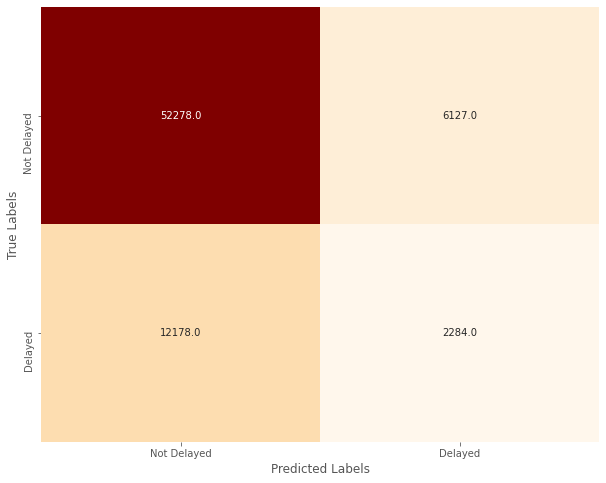

In [56]:
# Plot a confusion matrix of the test data
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True,
           fmt='.1f', xticklabels=['Not Delayed', 'Delayed'],
           yticklabels=['Not Delayed', 'Delayed'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show();

The confusion matrix above only further displays the model's test performance - there are 6,127 false positive predictions, which is worse than the past models I built and evaluated. The number of true positive cases increased, which gives me some hope that the model can be improved to levels that are acceptable for mass deployment. 

## Conclusion

This analysis leads to the following conclusions:

1. The neural networks performed better than the machine learning algorithms I tested in terms of precision, and is the algorithm I will utilize to improve my performance.

2. The model is exactly 27.2% precise when correctly classifying delayed flights.

## Limitations/Further Work

This project is limited in a few ways. First and foremost, I built my models under heavy computational constraints. Given the nature of the data, it is necessary to train models on computers that can process larger and fuller datasets in quicker time. For example, the grid search I performed earlier took almost 3 hours to run, despite a thin parameter grid. With improved hardware, I could use that same amount of time but apply techniques, like creating a better (more complete) parameter grid or analyzing larger data, to improve the model's performance. Another drawback is the class imbalance. I applied sampling methods to augment the minority class, which gave me more data to work with, but also increased my run times. Therefore, gathering more data that fall in the minority class would greatly improve my precision. Lastly, and this ties with my computational constraints, I mentioned I could have used a wider range of hyperparameters to perform my grid search with. Unfortunately, with limited resources, it would have taken me hours or even days to fully perform this search. However, I could have found a better set of hyperparameters that would improve my metrics and predictions. 

Further analyses could yield a more effective model, and possibly improve the algorithm's performance to the point where I push to market. Some possible courses of action I could take include:

1. Training my model with better, stronger hardware/computers.
2. Gathering more data with an emphasis on balancing the minority class to avoid sampling. 
3. Evaluating on different metrics to see how it impacts my model's performance.
4. Gain more feedback from peers and analyze the model with other methods (i.e., the Gradient Boosting classifier)

## Sources
Link to original dataset: 
https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations/data?select=full_data_flightdelay.csv

Wall Street Journal annual airlines ranking report:
https://www.wsj.com/lifestyle/travel/best-airlines-us-2023-36e9ea20

Bureau of Transportation Statistics:
https://www.transtats.bts.gov/HomeDrillChart.asp

Federal Aviation Administration (FAA):
https://aspm.faa.gov/aspmhelp/index/Types_of_Delay.html